This notebook focuses on embedding time into the features, running the models on each family before combining the predictions, and then using a blended XGBRegressor and Catboost model for the final predictions.

In [1]:
import numpy as np 
import pandas as pd 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train = pd.read_csv('train.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
test = pd.read_csv('test.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)

# Creating New Features

To combine the training and test datasets for feature engineering, both as a convenience and to account for carrying some of the temporal embedding of the features from the later period of the training dataset into the test dataset. 

In [3]:
train_test = pd.concat([train, test], ignore_index=True)

To change convert the date column into a datetime datatype and then to break out some basic calendar items as separate features. 

In [4]:
train_test.date = pd.to_datetime(train_test.date)

train_test['year'] = train_test.date.dt.year
train_test['month'] = train_test.date.dt.month
train_test['dayofmonth'] = train_test.date.dt.day
train_test['dayofweek'] = train_test.date.dt.dayofweek
train_test['dayname'] = train_test.date.dt.strftime('%A')

In [5]:
oil = pd.read_csv('oil.csv', parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')

To create a rolling 7 day mean as a basis for looking for trends in oil, create a separate dataframe to explore these trends and then forward fill missing data from the beginning of the 7 day rolling average values. Also tried 28 day rolling average for oil, but that increased the prediction scores. 

In [6]:
oil['avg_oil_7'] = oil['dcoilwtico'].rolling(7).mean()

In [7]:
trends = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31')).to_period('D')
trends = trends.join(oil, how='outer')
trends['avg_oil_7'].fillna(method = 'ffill', inplace = True)
trends.dropna(inplace = True)

Autocorrelation looks at the correlation of the values of a time series in successive periods. Partial autocorrelation removes any indirect correlation that may be present. Taking the 7 day rolling average for oil and projecting it forward 12 days shows that the first three lags have the most influence. Therefore 3 lags are added to the overall features. 

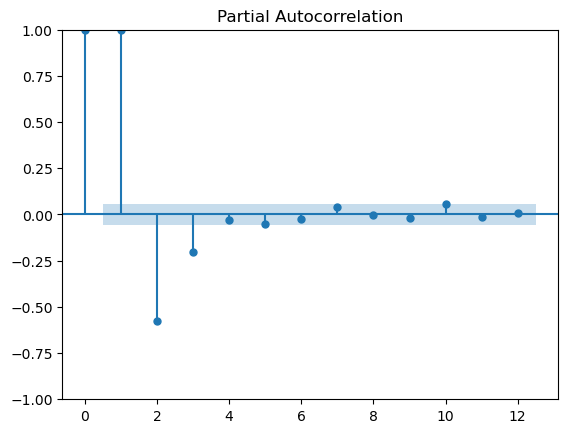

In [8]:
_ = plot_pacf(trends.avg_oil_7, lags = 12)

In [9]:
n_lags = 3
for l in range(1, n_lags+1):
    trends[f'oil_lags7_{l}'] = trends.avg_oil_7.shift(l)
trends.dropna(inplace = True)
trends.count()

dcoilwtico     1166
avg_oil_7      1166
oil_lags7_1    1166
oil_lags7_2    1166
oil_lags7_3    1166
dtype: int64

In [10]:
trends['date_str'] = trends.index.astype(str)
trends.drop('dcoilwtico', axis=1, inplace=True)

In [11]:
trends

,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3,date_str
2013-01-15,93.490000,93.470000,93.284286,93.218571,2013-01-15
2013-01-16,93.644286,93.490000,93.470000,93.284286,2013-01-16
2013-01-17,93.970000,93.644286,93.490000,93.470000,2013-01-17
2013-01-18,94.331429,93.970000,93.644286,93.490000,2013-01-18
2013-01-22,94.331429,94.331429,93.970000,93.644286,2013-01-22
...,...,...,...,...,...
2017-08-25,47.720000,47.598571,47.645714,47.522857,2017-08-25
2017-08-28,47.624286,47.720000,47.598571,47.645714,2017-08-28
2017-08-29,47.320000,47.624286,47.720000,47.598571,2017-08-29
2017-08-30,47.115714,47.320000,47.624286,47.720000,2017-08-30


The first day is missing oil data, so that is filled with the same value as the day after. 

There are also a number of days, primarily on weekends, where there is no oil data. Those dates are identified and then filled with the linear method. This method essentially draws a line between the two observed points and then filling the missing values so that they lie on this line. 

In [19]:
oil = oil.interpolate(method='linear')
oil.iloc[0] = oil.iloc[1]

start_date = train_test.date.min() 
number_of_days = 1704 
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date = (pd.Series(date_list)).to_frame()
date.columns = ['date']
date.date = pd.to_datetime(date.date)
date['date_str'] = date.date.astype(str)
oil['date_str'] = oil.index.astype(str)

oil = pd.merge(date,oil,how='left',on='date_str')
oil = oil.set_index('date').dcoilwtico.interpolate(method='linear').to_frame()
oil['date_str'] = oil.index.astype(str)

To add the oil and trends data to the primary train_test dataframe. 

In [13]:
train_test['date_str'] = train_test.date.astype(str)
train_test = pd.merge(train_test,oil,how='left',on='date_str')

In [14]:
train_test = pd.merge(train_test,trends,how='left',on='date_str')
train_test.drop(columns='date_str',axis=1,inplace=True)

In [15]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286


Creating new 7 day and 28 day rolling time features for promotions had a positive impact on the submission scores. 

In [16]:
train_test['onpromo_7'] = train_test['onpromotion'].rolling(7).mean()
train_test['onpromo_28'] = train_test['onpromotion'].rolling(28).mean()

In [17]:
train_test['onpromo_7'].fillna(0, inplace=True)
train_test['onpromo_28'].fillna(0, inplace=True)

To add the stores data to the train_test dataframe. 

In [18]:
stores = pd.read_csv('stores.csv',index_col='store_nbr')
train_test = pd.merge(train_test,stores,how='left',on='store_nbr')

To create national holiday features, including the core national holiday feature, a national event feature, a national work day feature and identifying weekend days. 

In [20]:
holiday = pd.read_csv('holidays_events.csv')
holiday.query('transferred==True')

holiday = holiday.query('transferred ==False')
holiday.description = holiday.description.str.replace('Traslado ','')

national = holiday.query('locale=="National"')
day_off = national.query('type!="Work Day" or type!="Event"').set_index('date')['description'].to_dict()
train_test['date_str'] = train_test.date.astype(str)
train_test['national_holiday'] = [1 if a in day_off else 0 for a in train_test.date_str]

event = national.query('type=="Event"').set_index('date')['description'].to_dict()
train_test['national_event'] =[1 if a in event else 0 for a in train_test.date_str]

work_day = national.query('type=="Work Day"').set_index('date')['description'].to_dict()
train_test['national_workday'] = [1 if a in work_day else 0 for a in train_test.date_str]

train_test['weekend'] = [1 if a>=5 else 0 for a in train_test.dayofweek]

To identify the local and regional holidays and add them to the train_test dataset. 

In [21]:
local = holiday.query('locale=="Local"')
local_dic = local.set_index('date').locale_name.to_dict()
train_test['local_holiday']=[1 if b in local_dic and local_dic[b]== a else 0 for a,b in zip(train_test.city,train_test.date_str)]

In [22]:
regional = holiday.query('locale=="Regional"')
regional_dic = regional.set_index('date').locale_name.to_dict()
train_test['regional_holiday']= [1 if b in regional_dic and regional_dic[b]== a else 0 for a,b in zip(train_test.state,train_test.date_str)]

In [23]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,state,type,cluster,date_str,national_holiday,national_event,national_workday,weekend,local_holiday,regional_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0


To log transform the sales data to reduce variance and skewness. 

In [24]:
train_test.sales = np.log1p(train_test.sales)

In [25]:
len(train_test.query('date_str=="2013-01-01"'))

1782

To create forward lags for sales for one week, the 16 days needed for the prediction, and then 6 days past the 16th day (a forward week), for one month (28, 30, 31 days), and one year. Since each day has 1782 rows (stores times families), each value is multiplied by 1782. 

In [26]:
train_test['Istest'] = False

train_test['Lag_7'] = train_test['sales'].shift(1782*7)

train_test['Lag_16'] = train_test['sales'].shift(1782*16)
train_test['Lag_17'] = train_test['sales'].shift(1782*17)
train_test['Lag_18'] = train_test['sales'].shift(1782*18)
train_test['Lag_19'] = train_test['sales'].shift(1782*19)
train_test['Lag_20'] = train_test['sales'].shift(1782*20)
train_test["Lag_21"] = train_test['sales'].shift(1782*21)
train_test['Lag_22'] = train_test['sales'].shift(1782*22)

train_test['Lag_28'] = train_test['sales'].shift(1782*28)
train_test['Lag_30'] = train_test['sales'].shift(1782*30)
train_test['Lag_31'] = train_test['sales'].shift(1782*31)

train_test['Lag_365'] = train_test['sales'].shift(1782*365)

train_test = train_test.query('Istest==False')

An exponential moving average is a type of moving average that gives more weight to recent observations, which means it’s able to capture recent trends more quickly. Alpha, which ranges from 0 to 1, determines how important the current observation is in the calculation of the EWMA. Alpha represents the degree of weighting decrease and is a constant smoothing factor. A higher alpha discounts older data faster thereby placing greater relevance on your more current data.

Below this is done for a range of alphas between 0.95 and 0.5, and for 1 day, 1 week, and one month. 

In [27]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            feature_name = 'sales_ewm_alpha_' + str(alpha).replace(".", "") + '_lag_' + str(lag)
            dataframe[feature_name] = dataframe.groupby(["store_nbr", "family"])['sales'].\
                transform(lambda x: x.shift(lag).ewm(alpha=alpha, min_periods=1).mean())
    return dataframe

In [28]:
alphas = [0.95, 0.8, 0.65, 0.5]
lags =[1, 7,30]
train_test = ewm_features(train_test, alphas, lags)

From the correlation data it appears the lowest alphas and lowest lags have the highest correlations to sales. Which means the older data is still important as part of the EWM calculations. 

In [29]:
corr = train_test.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.975231
sales_ewm_alpha_065_lag_1     0.973496
sales_ewm_alpha_08_lag_1      0.971192
sales_ewm_alpha_05_lag_7      0.971186
sales_ewm_alpha_065_lag_7     0.970779
sales_ewm_alpha_08_lag_7      0.969665
sales_ewm_alpha_095_lag_1     0.968111
sales_ewm_alpha_095_lag_7     0.967665
Lag_7                         0.966752
Lag_21                        0.947122
Lag_16                        0.941619
Lag_17                        0.939454
Lag_20                        0.939114
Lag_18                        0.938127
Lag_28                        0.937857
Lag_19                        0.937607
Lag_22                        0.935959
sales_ewm_alpha_05_lag_30     0.934552
sales_ewm_alpha_065_lag_30    0.931726
sales_ewm_alpha_08_lag_30     0.928695
sales_ewm_alpha_095_lag_30    0.925129
Lag_30                        0.923753
Lag_31                        0.922037
Lag_365                       0.850742
onpromotion              

Since lags have NaNs in the first part of their time periods, these are filled with 0 values. 

In [30]:
lags = ['Lag_7','Lag_16','Lag_17','Lag_18','Lag_19','Lag_20','Lag_21','Lag_22','Lag_28', 'Lag_30','Lag_31','Lag_365',
       'oil_lags7_1', 'oil_lags7_2', 'oil_lags7_3', 'avg_oil_7', 'sales_ewm_alpha_095_lag_1', 'sales_ewm_alpha_095_lag_7',
        'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_08_lag_1', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_30',
        'sales_ewm_alpha_065_lag_1', 'sales_ewm_alpha_065_lag_7', 'sales_ewm_alpha_065_lag_30', 'sales_ewm_alpha_05_lag_1',
        'sales_ewm_alpha_05_lag_7', 'sales_ewm_alpha_05_lag_30']

In [31]:
train_test[lags]=train_test[lags].fillna(0)

# Predicting and Submitting the Results

In [32]:
families = ['AUTOMOTIVE','BABY CARE','BEAUTY','BEVERAGES','BOOKS','BREAD/BAKERY','CELEBRATION','CLEANING','DAIRY',
            'DELI','EGGS','FROZEN FOODS','GROCERY I','GROCERY II','HARDWARE','HOME AND KITCHEN I','HOME AND KITCHEN II',
            'HOME APPLIANCES','HOME CARE','LADIESWEAR','LAWN AND GARDEN','LINGERIE','LIQUOR,WINE,BEER','MAGAZINES',
            'MEATS','PERSONAL CARE','PET SUPPLIES','PLAYERS AND ELECTRONICS','POULTRY','PREPARED FOODS','PRODUCE',
            'SCHOOL AND OFFICE SUPPLIES','SEAFOOD']

In [33]:
print(train_test.columns.tolist())

['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month', 'dayofmonth', 'dayofweek', 'dayname', 'dcoilwtico', 'avg_oil_7', 'oil_lags7_1', 'oil_lags7_2', 'oil_lags7_3', 'onpromo_7', 'onpromo_28', 'city', 'state', 'type', 'cluster', 'date_str', 'national_holiday', 'national_event', 'national_workday', 'weekend', 'local_holiday', 'regional_holiday', 'Istest', 'Lag_7', 'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22', 'Lag_28', 'Lag_30', 'Lag_31', 'Lag_365', 'sales_ewm_alpha_095_lag_1', 'sales_ewm_alpha_095_lag_7', 'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_08_lag_1', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_30', 'sales_ewm_alpha_065_lag_1', 'sales_ewm_alpha_065_lag_7', 'sales_ewm_alpha_065_lag_30', 'sales_ewm_alpha_05_lag_1', 'sales_ewm_alpha_05_lag_7', 'sales_ewm_alpha_05_lag_30']


To identify the features that won't be used as the dependent variables for the prediction process. 

In [34]:
FEATURES = train_test.columns.tolist()
no_features = ('date', 'family', 'sales', 'dayname', 'date_str', 'Istest')

for i in no_features:
    FEATURES.remove(i)
TARGET =['sales']

To use encoding to transform the categorical values to numbers. 

In [35]:
categories = ['city','state', 'type']
for i in categories:
    encoder = preprocessing.LabelEncoder()
    train_test[i] = encoder.fit_transform(train_test[i])

To split back out the training and test dataframes with the new features. 

In [36]:
train = train_test[train_test['sales'].notnull()].copy()
test = train_test[train_test['sales'].isnull()].drop(['sales'],axis=1)

In experimenting with the dates it was found that the best results came from only including the data from 2016 forward. 

In [37]:
train = train.query("date >= '2016-01-01' ")

In [38]:
train

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_065_lag_1,sales_ewm_alpha_065_lag_7,sales_ewm_alpha_065_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
1945944,2016-01-01,1,AUTOMOTIVE,0.000000,0,2016,1,1,4,Friday,...,1.317202,1.803400,1.677389,1.122943,1.817994,1.697249,0.973111,1.827742,1.657195,0.892811
1945945,2016-01-01,1,BABY CARE,0.000000,0,2016,1,1,4,Friday,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1945946,2016-01-01,1,BEAUTY,0.000000,0,2016,1,1,4,Friday,...,1.943741,0.178375,1.221152,1.908997,0.274128,1.293594,1.828294,0.374116,1.354975,1.702942
1945947,2016-01-01,1,BEVERAGES,0.000000,0,2016,1,1,4,Friday,...,7.804765,7.711394,7.735110,7.773221,7.703508,7.747519,7.724412,7.668357,7.747519,7.670928
1945948,2016-01-01,1,BOOKS,0.000000,0,2016,1,1,4,Friday,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,6.084802,0,2017,8,15,1,Tuesday,...,6.344168,5.724007,5.943887,6.320788,5.778189,6.000674,6.283348,5.829966,6.062661,6.230597
3000884,2017-08-15,9,PREPARED FOODS,5.046987,1,2017,8,15,1,Tuesday,...,4.849691,4.737019,4.757764,4.858467,4.737446,4.783436,4.851238,4.742214,4.803638,4.827482
3000885,2017-08-15,9,PRODUCE,7.791824,148,2017,8,15,1,Tuesday,...,7.613556,7.245679,7.681609,7.578174,7.263540,7.639393,7.530851,7.272816,7.593833,7.479115
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,4.804021,8,2017,8,15,1,Tuesday,...,0.052401,5.213560,5.120861,0.188557,5.196824,5.112156,0.313338,5.161940,5.098202,0.446829


Optuna was used to find the optimal parameters for XBGRegressor. The values below were what were identified. The same process was run on Catboost Regressor, but those parameter values - for some reason - did not improve the score from default parameters. 

In [42]:
params = {'lambda': 6.105970537016599, 
          'alpha': 0.874716179324655, 
          'eta': 0.047228549789593455, 
          'colsample_bytree': 0.5, 
          'subsample': 0.7, 
          'learning_rate': 0.012, 
          'n_estimators': 1000, 
          'max_depth': 17, 
          'min_child_weight': 155,
          'early_stopping_rounds': 10}

The following code runs the fitting and prediction for both catboost and xgb by each product family. Since each family might have their own sales behaviors, this process could provide a more accurate prediction. In reality the overall score is higher using this approach instead of estimating future sales based on the overall, global model.

Also running the predictions for the test dataset in this loop created a better result than running it in a separate loop. 

In [43]:
cat_predictions = []
xgb_predictions = []
y_val_cat = pd.DataFrame()
y_val_xgb = pd.DataFrame()
cat = CatBoostRegressor()
xgb = XGBRegressor(**params)

test_predict = pd.DataFrame()

cat_submit = []
xgb_submit = []

for family in families:
    train_family = train.loc[train['family'] == family]
    X_train_family,X_val_family,y_train_family,y_val_family = train_test_split(train_family,
                                                                               train_family[TARGET],
                                                                               test_size=0.05,shuffle=False)
    
    cat.fit(X_train_family[FEATURES], y_train_family, eval_set=[(X_train_family[FEATURES],y_train_family),
                                                               (X_val_family[FEATURES], y_val_family)], 
            verbose=False,early_stopping_rounds=10)
    
    xgb.fit(X_train_family[FEATURES], y_train_family, eval_set=[(X_train_family[FEATURES],y_train_family),
                                                                (X_val_family[FEATURES], y_val_family)],
            verbose=False)
    
    cat_pred_family = cat.predict(X_val_family[FEATURES])
    cat_pred_family = [a if a>0 else 0 for a in cat_pred_family]
    cat_predictions.extend(cat_pred_family)
    y_val_cat = y_val_cat.append(y_val_family)
    
    xgb_pred_family = xgb.predict(X_val_family[FEATURES])
    xgb_pred_family = [a if a>0 else 0 for a in xgb_pred_family]
    xgb_predictions.extend(xgb_pred_family)
    y_val_xgb = y_val_xgb.append(y_val_family)
    
    test_family = test.loc[test['family'] == family]
    
    cat_pred_submit = cat.predict(test_family[FEATURES])
    cat_pred_submit = [a if a>0 else 0 for a in cat_pred_submit]
    cat_submit.extend(cat_pred_submit)
    
    xgb_pred_submit = xgb.predict(test_family[FEATURES])
    xgb_pred_submit = [a if a>0 else 0 for a in xgb_pred_submit]
    xgb_submit.extend(xgb_pred_submit)
    
    test_predict = test_predict.append(test_family)
    
    print(family,'CatBoost RMSLE:', np.sqrt(mean_squared_log_error(y_val_family, cat_pred_family)))
    print(family,'XGB RMSLE:', np.sqrt(mean_squared_log_error(y_val_family, xgb_pred_family)))

AUTOMOTIVE CatBoost RMSLE: 0.2214993566786253
AUTOMOTIVE XGB RMSLE: 0.22078025615687216
BABY CARE CatBoost RMSLE: 0.18639845177862482
BABY CARE XGB RMSLE: 0.18781423094808922
BEAUTY CatBoost RMSLE: 0.2386358904837846
BEAUTY XGB RMSLE: 0.23701526522786412
BEVERAGES CatBoost RMSLE: 0.02374335014392371
BEVERAGES XGB RMSLE: 0.024112675460318443
BOOKS CatBoost RMSLE: 0.07720648359738554
BOOKS XGB RMSLE: 0.0747278317838257
BREAD/BAKERY CatBoost RMSLE: 0.024862892647899926
BREAD/BAKERY XGB RMSLE: 0.024739153878882685
CELEBRATION CatBoost RMSLE: 0.20339820188713453
CELEBRATION XGB RMSLE: 0.20308024310226314
CLEANING CatBoost RMSLE: 0.03442715194852634
CLEANING XGB RMSLE: 0.033958081309992394
DAIRY CatBoost RMSLE: 0.0215391856973794
DAIRY XGB RMSLE: 0.021548531225992977
DELI CatBoost RMSLE: 0.02850274182140867
DELI XGB RMSLE: 0.02863828688761647
EGGS CatBoost RMSLE: 0.05538764494669414
EGGS XGB RMSLE: 0.055301304682652985
FROZEN FOODS CatBoost RMSLE: 0.05319307221403199
FROZEN FOODS XGB RMSLE: 

Once the results are run for each product family, the following code looks at the overall score for the combined family predictions. 

In [66]:
len(cat_predictions)

52767

In [67]:
y_val_cat['pred'] = cat_predictions
y_val_xgb['pred'] = xgb_predictions

In [68]:
y_val_cat

,sales,pred
2948121,1.386294,1.933608
2948154,2.197225,2.209722
2948187,1.098612,1.247467
2948220,1.791759,2.049322
2948253,0.693147,1.067232
...,...,...
3000755,1.386294,0.981800
3000788,3.883109,3.388921
3000821,3.860877,3.653929
3000854,3.191710,3.225831


In [69]:
y_val_xgb

,sales,pred
2948121,1.386294,1.870255
2948154,2.197225,2.215037
2948187,1.098612,1.092680
2948220,1.791759,2.130626
2948253,0.693147,0.985776
...,...,...
3000755,1.386294,1.013507
3000788,3.883109,3.364231
3000821,3.860877,3.608617
3000854,3.191710,3.208916


In [70]:
print('Overall CatBoost RMSLE:', np.sqrt(mean_squared_log_error(y_val_cat['sales'], y_val_cat['pred'])))
print('Overall XGB RMSLE:', np.sqrt(mean_squared_log_error(y_val_xgb['sales'], y_val_xgb['pred'])))

Overall CatBoost RMSLE: 0.16442019470974428
Overall XGB RMSLE: 0.1645888517465122


The test_predict dataset was created in the families iteration loop to match the sorting of the test data against the predictions generated in the iteration process. 

In [71]:
test

,date,store_nbr,family,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,...,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_065_lag_1,sales_ewm_alpha_065_lag_7,sales_ewm_alpha_065_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30,pred
3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.434693e+00,2.003007e+00,1.130841,1.331482e+00,1.965301,1.196755,1.274187,1.937902,1.299413,1.522182
3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,Wednesday,46.80,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.915332
3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,Wednesday,46.80,...,1.631548e+00,1.530109e+00,1.676479,1.600347e+00,1.492915,1.615232,1.546607,1.471745,1.574487,1.680641
3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,Wednesday,46.80,...,7.561987e+00,7.744151e+00,7.646603,7.520365e+00,7.722962,7.589360,7.467557,7.687524,7.566229,1.503440
3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,Wednesday,46.80,...,1.817044e-11,2.839131e-07,0.561584,6.527692e-08,0.000036,0.482003,0.000011,0.000677,0.421012,1.427328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,2017,8,31,3,Thursday,47.26,...,6.012643e+00,6.012643e+00,6.311631,5.977488e+00,5.977488,6.283037,5.957384,5.957384,6.244803,0.807816
3029396,2017-08-31,9,PREPARED FOODS,0,2017,8,31,3,Thursday,47.26,...,4.984993e+00,4.984993e+00,4.014010,4.938647e+00,4.938647,4.105066,4.894600,4.894600,4.210488,3.311228
3029397,2017-08-31,9,PRODUCE,1,2017,8,31,3,Thursday,47.26,...,7.682595e+00,7.682595e+00,7.722496,7.606924e+00,7.606924,7.659226,7.532320,7.532320,7.590557,3.453404
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017,8,31,3,Thursday,47.26,...,4.885929e+00,4.885929e+00,5.043656,4.941502e+00,4.941502,4.787096,4.982981,4.982981,4.438414,3.226994


In [72]:
test_predict

,date,store_nbr,family,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,...,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_065_lag_1,sales_ewm_alpha_065_lag_7,sales_ewm_alpha_065_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30,pred
3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.434693,2.003007,1.130841,1.331482,1.965301,1.196755,1.274187,1.937902,1.299413,1.522182
3000921,2017-08-16,10,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.406966,1.162304,0.223640,1.247107,1.059775,0.330414,1.096715,1.005711,0.402113,1.394836
3000954,2017-08-16,11,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.814450,1.374426,1.634666,1.773433,1.570789,1.780836,1.786136,1.765173,1.891973,1.956553
3000987,2017-08-16,12,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.289576,1.483775,1.190560,1.452258,1.539915,1.292815,1.616909,1.593787,1.413183,2.182972
3001020,2017-08-16,13,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.516116,1.936916,1.172947,1.473993,1.928978,1.224016,1.468716,1.928373,1.257964,1.960371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029267,2017-08-31,54,SEAFOOD,0,2017,8,31,3,Thursday,47.26,...,1.149017,1.149017,1.430784,1.014662,1.014662,1.462440,0.914625,0.914625,1.487740,0.488154
3029300,2017-08-31,6,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,3.851917,3.851917,3.549771,3.837381,3.837381,3.577259,3.817350,3.817350,3.592524,2.263952
3029333,2017-08-31,7,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,3.854837,3.854837,3.748958,3.837833,3.837833,3.755091,3.814197,3.814197,3.755749,4.045055
3029366,2017-08-31,8,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,3.260691,3.260691,3.564830,3.311866,3.311866,3.632429,3.363862,3.363862,3.690210,1.567500


The cat_submit and xgb_submit predictions are blended to create overall predictions combining the catboost and xgb results. 

In [73]:
len(cat_submit)

28512

In [74]:
len(xgb_submit)

28512

In [75]:
predictions = [0.5 * a + 0.5 * b for a,b in zip(xgb_submit,cat_submit)] 

In [76]:
len(predictions)

28512

These overall predictions are placed into the test_predict dataset and then that dataset is sorted by the id index so that it will match the formatting of the necessary submission file. 

In [77]:
test_predict['pred'] = predictions

In [78]:
test_predict

,date,store_nbr,family,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,...,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_065_lag_1,sales_ewm_alpha_065_lag_7,sales_ewm_alpha_065_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30,pred
3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.434693,2.003007,1.130841,1.331482,1.965301,1.196755,1.274187,1.937902,1.299413,1.522182
3000921,2017-08-16,10,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.406966,1.162304,0.223640,1.247107,1.059775,0.330414,1.096715,1.005711,0.402113,0.915332
3000954,2017-08-16,11,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.814450,1.374426,1.634666,1.773433,1.570789,1.780836,1.786136,1.765173,1.891973,1.680641
3000987,2017-08-16,12,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.289576,1.483775,1.190560,1.452258,1.539915,1.292815,1.616909,1.593787,1.413183,1.503440
3001020,2017-08-16,13,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.516116,1.936916,1.172947,1.473993,1.928978,1.224016,1.468716,1.928373,1.257964,1.427328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029267,2017-08-31,54,SEAFOOD,0,2017,8,31,3,Thursday,47.26,...,1.149017,1.149017,1.430784,1.014662,1.014662,1.462440,0.914625,0.914625,1.487740,0.807816
3029300,2017-08-31,6,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,3.851917,3.851917,3.549771,3.837381,3.837381,3.577259,3.817350,3.817350,3.592524,3.311228
3029333,2017-08-31,7,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,3.854837,3.854837,3.748958,3.837833,3.837833,3.755091,3.814197,3.814197,3.755749,3.453404
3029366,2017-08-31,8,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,3.260691,3.260691,3.564830,3.311866,3.311866,3.632429,3.363862,3.363862,3.690210,3.226994


In [79]:
test_predict.sort_index(inplace=True)

In [80]:
test_predict

,date,store_nbr,family,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,...,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_065_lag_1,sales_ewm_alpha_065_lag_7,sales_ewm_alpha_065_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30,pred
3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,1.434693e+00,2.003007e+00,1.130841,1.331482e+00,1.965301,1.196755,1.274187,1.937902,1.299413,1.522182
3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,Wednesday,46.80,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.013052
3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,Wednesday,46.80,...,1.631548e+00,1.530109e+00,1.676479,1.600347e+00,1.492915,1.615232,1.546607,1.471745,1.574487,1.616784
3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,Wednesday,46.80,...,7.561987e+00,7.744151e+00,7.646603,7.520365e+00,7.722962,7.589360,7.467557,7.687524,7.566229,7.687754
3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,Wednesday,46.80,...,1.817044e-11,2.839131e-07,0.561584,6.527692e-08,0.000036,0.482003,0.000011,0.000677,0.421012,0.055138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,2017,8,31,3,Thursday,47.26,...,6.012643e+00,6.012643e+00,6.311631,5.977488e+00,5.977488,6.283037,5.957384,5.957384,6.244803,5.920339
3029396,2017-08-31,9,PREPARED FOODS,0,2017,8,31,3,Thursday,47.26,...,4.984993e+00,4.984993e+00,4.014010,4.938647e+00,4.938647,4.105066,4.894600,4.894600,4.210488,4.721826
3029397,2017-08-31,9,PRODUCE,1,2017,8,31,3,Thursday,47.26,...,7.682595e+00,7.682595e+00,7.722496,7.606924e+00,7.606924,7.659226,7.532320,7.532320,7.590557,7.103894
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017,8,31,3,Thursday,47.26,...,4.885929e+00,4.885929e+00,5.043656,4.941502e+00,4.941502,4.787096,4.982981,4.982981,4.438414,4.640397


In [81]:
output = pd.read_csv('sample_submission.csv',index_col='id')
output['sales']= np.expm1(test_predict['pred'])

In [82]:
output

,sales
id,
3000888,3.582211
3000889,0.013138
3000890,4.036867
3000891,2180.469405
3000892,0.056687
...,...
3029395,371.537876
3029396,111.373289
3029397,1215.695772


In [83]:
output.to_csv('./submissions/submit-families.csv')